# Tutorial 5 - CodeGen and External Function Interfacing
- There are many other existing Agentic Frameworks like Crew.ai, LangChain / LangGraph, LlamaIndex that have many pre-established tools
- TaskGen provides an easy way to interface with them and input them directly into TaskGen Agents!
- We also show how to implement the Code as Actions agent (Executable Code Actions Elicit Better LLM Agents (Wang et al, 2024)
- https://arxiv.org/abs/2402.01030)

# Setup Guide

## Step 1: Install TaskGen

In [1]:
# !pip install taskgen-ai

## Step 2: Import required functions and setup relevant API keys for your LLM

In [2]:
# Set up API key and do the necessary imports
from taskgen import *
import os

# this is only if you use OpenAI as your LLM
os.environ['OPENAI_API_KEY'] = '<YOUR API KEY HERE>'

## Step 3: Define your own LLM
- Define an `llm` function that takes in as inputs `system_prompt` and `user_prompt`, and outputs llm response string
- Note: If you do not define your own LLM, OpenAI `gpt-3.5-turbo` will be used as default

In [3]:
def llm(system_prompt: str, user_prompt: str) -> str:
    ''' Here, we use OpenAI for illustration, you can change it to your own LLM '''
    # ensure your LLM imports are all within this function
    from openai import OpenAI
    
    # define your own LLM here
    client = OpenAI()
    response = client.chat.completions.create(
        model='gpt-3.5-turbo',
        temperature = 0,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ]
    )
    return response.choices[0].message.content

In [4]:
# Verify that llm function is working
llm(system_prompt = 'You are a classifier to classify the sentiment of a sentence', 
    user_prompt = 'It is a hot and sunny day')

'Positive'

# CrewAI Structured Tools Interface with TaskGen

In [5]:
# !pip install crewai==0.28.8 crewai_tools==0.1.6 langchain_community==0.0.29

In [6]:
def query_pdf_tool(query: str):
    ''' Returns the answer to the query '''
    from crewai_tools import PDFSearchTool
    file_path = 'react.pdf'
    
    return PDFSearchTool(pdf=file_path).run(query)

In [7]:
!wget https://arxiv.org/pdf/2210.03629 -O react.pdf

--2024-07-10 00:32:31--  https://arxiv.org/pdf/2210.03629
Resolving arxiv.org (arxiv.org)... 151.101.195.42, 151.101.131.42, 151.101.67.42, ...
Connecting to arxiv.org (arxiv.org)|151.101.195.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 633805 (619K) [application/pdf]
Saving to: ‘react.pdf’

react.pdf           100%[===================>] 618.95K  --.-KB/s    in 0.02s   

2024-07-10 00:32:31 (25.6 MB/s) - ‘react.pdf’ saved [633805/633805]



In [8]:
query_pdf_tool('What is ReAct?')

Using Tool: Search a PDF's content


'Relevant Content:\nReAct-IM is in\n\nand gather additional information from external sources such as knowledge bases or environments. We apply our approach, named ReAct , to a diverse set of language and decision making tasks and demonstrate its effectiveness over state-of-the-art baselines in addition to improved human interpretability and trustworthiness. Concretely, on question answering (HotpotQA) and fact veriﬁcation (Fever), ReAct overcomes prevalent issues of hallucination and error propagation in chain-of-thought reasoning by interacting with a simple Wikipedia API, and generating human-like task-solving trajectories that are more interpretable than baselines without reasoning traces. Furthermore, on two interactive decision making benchmarks (ALFWorld and WebShop), ReAct outperforms imitation and reinforcement learning methods by an absolute success rate of 34% and 10% respectively, while being prompted with only one or two in-context examples. 1 I NTRODUCTION A unique featur

In [9]:
agent = Agent('PDF Query Agent', 
              '''Returns the answer to the query''',
              llm = llm).assign_functions([query_pdf_tool])

In [10]:
agent.print_functions()

Name: use_llm
Description: For general tasks. Used only when no other function can do the task
Input: []
Output: {'Output': 'Output of LLM'}

Name: end_task
Description: Passes the final output to the user
Input: []
Output: {}

Name: query_pdf_tool
Description:  Returns the answer to the <query: str> 
Input: ['query']
Output: {}



In [11]:
agent.reset()
agent.run('What is ReAct?')

Observation: No subtasks have been completed yet for the assigned task.
Thoughts: Since no subtasks have been completed, it is necessary to start by understanding the query 'What is ReAct?' and then proceed accordingly.
Subtask identified: Use the 'query_pdf_tool' function to get the answer to the query 'What is ReAct?'
Calling function query_pdf_tool with parameters {'query': 'What is ReAct?'}
Using Tool: Search a PDF's content
> {'output_1': 'Relevant Content:\nReAct-IM is in\n\nand gather additional information from external sources such as knowledge bases or environments. We apply our approach, named ReAct , to a diverse set of language and decision making tasks and demonstrate its effectiveness over state-of-the-art baselines in addition to improved human interpretability and trustworthiness. Concretely, on question answering (HotpotQA) and fact veriﬁcation (Fever), ReAct overcomes prevalent issues of hallucination and error propagation in chain-of-thought reasoning by interacting

[{'output_1': 'Relevant Content:\nReAct-IM is in\n\nand gather additional information from external sources such as knowledge bases or environments. We apply our approach, named ReAct , to a diverse set of language and decision making tasks and demonstrate its effectiveness over state-of-the-art baselines in addition to improved human interpretability and trustworthiness. Concretely, on question answering (HotpotQA) and fact veriﬁcation (Fever), ReAct overcomes prevalent issues of hallucination and error propagation in chain-of-thought reasoning by interacting with a simple Wikipedia API, and generating human-like task-solving trajectories that are more interpretable than baselines without reasoning traces. Furthermore, on two interactive decision making benchmarks (ALFWorld and WebShop), ReAct outperforms imitation and reinforcement learning methods by an absolute success rate of 34% and 10% respectively, while being prompted with only one or two in-context examples. 1 I NTRODUCTION A

In [12]:
agent.reply_user()

ReAct is a tool that applies an approach to a diverse set of language and decision-making tasks. It demonstrates effectiveness over state-of-the-art baselines, improved human interpretability, and trustworthiness. ReAct overcomes prevalent issues of hallucination and error propagation in reasoning tasks by interacting with a simple Wikipedia API and generating human-like task-solving trajectories that are more interpretable than baselines without reasoning traces. It outperforms imitation and reinforcement learning methods on interactive decision-making benchmarks by a significant margin, even with minimal in-context examples. ReAct integrates decision-making and reasoning capabilities into a large language model, making it intuitive, easy to design, general, flexible, performant, and robust.


'ReAct is a tool that applies an approach to a diverse set of language and decision-making tasks. It demonstrates effectiveness over state-of-the-art baselines, improved human interpretability, and trustworthiness. ReAct overcomes prevalent issues of hallucination and error propagation in reasoning tasks by interacting with a simple Wikipedia API and generating human-like task-solving trajectories that are more interpretable than baselines without reasoning traces. It outperforms imitation and reinforcement learning methods on interactive decision-making benchmarks by a significant margin, even with minimal in-context examples. ReAct integrates decision-making and reasoning capabilities into a large language model, making it intuitive, easy to design, general, flexible, performant, and robust.'

In [13]:
# just wrap the external tool within a function
def scrape_website_tool(website_url: str) -> str:
    ''' Scrapes data from a website_url '''
    # import the tool
    from crewai_tools import ScrapeWebsiteTool
    
    # initialise the tool
    docs_scrape_tool = ScrapeWebsiteTool(
        website_url=website_url)
    
    # run the tool
    return docs_scrape_tool.run()

In [14]:
agent = Agent('Website summariser', 
              'Scrapes websites and summarises the findings to the user', 
              summarise_subtasks_count = 5, # this summarises the subtasks after a certain number of subtasks to reduce context length
              llm = llm).assign_functions([scrape_website_tool])

In [15]:
agent.print_functions()

Name: use_llm
Description: For general tasks. Used only when no other function can do the task
Input: []
Output: {'Output': 'Output of LLM'}

Name: end_task
Description: Passes the final output to the user
Input: []
Output: {}

Name: scrape_website_tool
Description:  Scrapes data from a <website_url: str> 
Input: ['website_url']
Output: {'output_1': 'str'}



In [16]:
agent.reset()
agent.run('What are the differences between TaskGen ("https://github.com/simbianai/taskgen") and CrewAI ("https://github.com/joaomdmoura/CrewAI")?')

Observation: No subtasks have been completed yet.
Thoughts: Need to start by scraping the websites provided in the Assigned Task to gather information on TaskGen and CrewAI.
Subtask identified: Scrape data from the website 'https://github.com/simbianai/taskgen' to gather information on TaskGen.
Calling function scrape_website_tool with parameters {'website_url': 'https://github.com/simbianai/taskgen'}
Using Tool: Read website content
> {'output_1': 'GitHub - simbianai/taskgen: Task-based Agentic Framework using StrictJSON as the core\nSkip to content\nNavigation Menu\nToggle navigation\n Sign in\n Product\nActions\n Automate any workflow\nPackages\n Host and manage packages\nSecurity\n Find and fix vulnerabilities\nCodespaces\n Instant dev environments\nGitHub Copilot\n Write better code with AI\nCode review\n Manage code changes\nIssues\n Plan and track work\nDiscussions\n Collaborate outside of code\nExplore\n All features\n Documentation\n GitHub Skills\n Blog\n Solutions\nBy size\n

[{'output_1': 'GitHub - simbianai/taskgen: Task-based Agentic Framework using StrictJSON as the core\nSkip to content\nNavigation Menu\nToggle navigation\n Sign in\n Product\nActions\n Automate any workflow\nPackages\n Host and manage packages\nSecurity\n Find and fix vulnerabilities\nCodespaces\n Instant dev environments\nGitHub Copilot\n Write better code with AI\nCode review\n Manage code changes\nIssues\n Plan and track work\nDiscussions\n Collaborate outside of code\nExplore\n All features\n Documentation\n GitHub Skills\n Blog\n Solutions\nBy size\n Enterprise\n Teams\n Startups\nBy industry\n Healthcare\n Financial services\n Manufacturing\nBy use case\n CI/CD & Automation\n DevOps\n DevSecOps\n Resources\nResources\n Learning Pathways\n White papers, Ebooks, Webinars\n Customer Stories\n Partners\n Open Source\nGitHub Sponsors\n Fund open source developers\nThe ReadME Project\n GitHub community articles\nRepositories\n Topics\n Trending\n Collections\n Enterprise\nEnterprise pl

In [17]:
agent.reply_user('What are the key imports needed?')

The key imports needed for TaskGen are: Agent, Function, AsyncFunction, and Crew from crewai. Additionally, the SerperDevTool from crewai_tools is also required for setting up the crew. For CrewAI, the necessary imports include Agent, Task, Crew, Process, and SerperDevTool from crewai, as well as the SerperDevTool from crewai_tools for setting up the crew.


'The key imports needed for TaskGen are: Agent, Function, AsyncFunction, and Crew from crewai. Additionally, the SerperDevTool from crewai_tools is also required for setting up the crew. For CrewAI, the necessary imports include Agent, Task, Crew, Process, and SerperDevTool from crewai, as well as the SerperDevTool from crewai_tools for setting up the crew.'

In [18]:
agent.reply_user('What version of packages are they compatible with?')

TaskGen is compatible with Python version 3.7 and above. CrewAI is compatible with Python version 3.6 and above. Both frameworks require the installation of dependencies using Poetry, and CrewAI also supports virtual environments for managing dependencies.


'TaskGen is compatible with Python version 3.7 and above. CrewAI is compatible with Python version 3.6 and above. Both frameworks require the installation of dependencies using Poetry, and CrewAI also supports virtual environments for managing dependencies.'

# LangChain Structured Tools Interface with TaskGen
- If User defines a function in LangChain, simply just add <fn_name>.func to TaskGen Agent

In [19]:
from langchain_core.tools import tool

@tool
def add(num1: int, num2: int) -> int:
    """Adds num1 and num2."""
    return num1 + num2


@tool
def multiply(num1: int, num2: int) -> int:
    """Multiplies num1 and num2."""
    return num1 * num2


tools = [add, multiply]

In [20]:
from taskgen import Agent
agent = Agent('Math Whiz', 'Does calculations',
             llm = llm).assign_functions([add.func, multiply.func])

In [21]:
agent.list_functions()

["Name: use_llm\nDescription: For general tasks. Used only when no other function can do the task\nInput: []\nOutput: {'Output': 'Output of LLM'}\n",
 'Name: end_task\nDescription: Passes the final output to the user\nInput: []\nOutput: {}\n',
 "Name: add\nDescription: Adds <num1: int> and <num2: int>.\nInput: ['num1', 'num2']\nOutput: {'output_1': 'int'}\n",
 "Name: multiply\nDescription: Multiplies <num1: int> and <num2: int>.\nInput: ['num1', 'num2']\nOutput: {'output_1': 'int'}\n"]

In [22]:
agent.run('Calculate 3*5 + 3')

Observation: No subtasks have been completed yet.
Thoughts: To complete the remainder of the Assigned Task, I need to perform the calculation 3*5 + 3.
Subtask identified: Multiply 3 by 5 and then add 3 to the result.
Calling function add with parameters {'num1': 3, 'num2': 5}
> {'output_1': 8}

Observation: The addition subtask has been completed successfully.
Thoughts: To complete the remainder of the Assigned Task, we need to multiply the result of the addition by 3.
Subtask identified: Multiply the result of the addition (8) by 3.
Calling function multiply with parameters {'num1': 8, 'num2': 3}
> {'output_1': 24}

Observation: The subtasks completed so far involved adding 3 and 5 to get 8, and then multiplying the result by 3 to get 24.
Thoughts: To complete the remainder of the assigned task, we need to add 3 to the result obtained from the previous multiplication.
Subtask identified: Add 3 to the result obtained from the previous multiplication (24).
Calling function add with para

[{'output_1': 8},
 {'output_1': 24},
 {'output_1': 27},
 {'output_1': 30},
 {'output_1': 33}]

# LangChain Community Tools Interface with TaskGen
- See https://python.langchain.com/v0.2/docs/integrations/providers/ for full list
- Wikipedia
- Python REPL (not that great to run many things - have created my own in TaskGen)

In [23]:
# !pip -q install wikipedia

In [24]:
def wikipedia_tool(search_query: str) -> str:
    ''' Uses search_query and returns text from wikipedia '''
    from langchain.tools import WikipediaQueryRun
    from langchain.utilities import WikipediaAPIWrapper

    return WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper()).run(search_query)

In [25]:
wikipedia_tool('Joe Biden')[:100]

'Page: Joe Biden\nSummary: Joseph Robinette Biden Jr. (born November 20, 1942) is an American politici'

In [26]:
def python_repl_tool(python_code: str) -> str:
    ''' Runs python_code, returns the final result, or any debugging errors '''
    from langchain.utilities import PythonREPL
    
    return PythonREPL().run(python_code)

In [27]:
python_repl_tool('print(3+5)')

2024-07-10 00:33:35,243 - 140704584034048 - python.py-python:16 - WARNING: Python REPL can execute arbitrary code. Use with caution.


'8\n'

# LlamaIndex Function Interface with TaskGen
- If User defines a function in LlamaIndex, simply just add <fn_name>.fn to TaskGen Agent
- TODO: Add structure for other kinds of functions in LlamaIndex

In [28]:
# !pip install llama-index

In [29]:
from llama_index.core.tools import FunctionTool

def get_weather(location: str) -> str:
    """Usfeful for getting the weather for a given location."""
    return 'Sunny'
    ...

tool = FunctionTool.from_defaults(
    get_weather,
    # async_fn=aget_weather,  # optional!
)

In [30]:
agent = Agent('Weather Agent', 'Returns the Weather',
             llm = llm).assign_functions(tool.fn)

In [31]:
agent.list_functions()

["Name: use_llm\nDescription: For general tasks. Used only when no other function can do the task\nInput: []\nOutput: {'Output': 'Output of LLM'}\n",
 'Name: end_task\nDescription: Passes the final output to the user\nInput: []\nOutput: {}\n',
 "Name: get_weather\nDescription: Usfeful for getting the weather for a given <location: str>.\nInput: ['location']\nOutput: {'output_1': 'str'}\n"]

In [32]:
agent.run('What is the weather in Miami?')

Observation: No subtasks have been completed yet.
Thoughts: Since no subtasks have been completed, it is important to start by identifying the key information needed to complete the Assigned Task.
Subtask identified: Use the 'get_weather' function to get the weather for the location 'Miami'.
Calling function get_weather with parameters {'location': 'Miami'}
> {'output_1': 'Sunny'}

Observation: The weather for Miami has been successfully retrieved as 'Sunny'.
Thoughts: Since the weather for Miami has already been obtained, the next step is to pass this final output to the user.
Subtask identified: End Task
Task completed successfully!



[{'output_1': 'Sunny'}]

# TaskGen Custom Tools
- Some initial tools TaskGen can provide are as follows:
    - Code generator: `python_generator_tool`
    - Code executor: `python_run_tool`
    - Code debugger: `python_debug_tool`
    - Code generator, executor and debugger combined: `python_generate_and_run_code_tool`
    - Webpage parser: `get_text_from_url_tool`

In [33]:
shared_variables = {'agent': Agent('Generalist Agent', 'Does Everything').assign_functions([wikipedia_tool])}

In [34]:
def python_generator_tool(shared_variables, instruction: str):
    '''Generate code only based on instruction without any additional context.
Ensure that you define all variables and list out all imports.
You can only import the following modules: math, numpy, random, datetime, re, matplotlib, pandas, plotly
Do not define any new functions
You are able to use all Equipped Functions except use_llm and end_task
The output of Equipped Function will be in a dictionary format
Ensure all required output are in print()'''
    
    agent = shared_variables['agent']
    
    return strict_json(f'''Generate code based only on ```{instruction}``` without additional context.
Ensure that you define all variables and list out all imports.
You can only import the following modules: math, numpy, random, datetime, re, matplotlib, pandas, plotly
Do not define any new functions
You are able to use the following Equipped Functions: 
```{agent.list_functions(
fn_list = [agent.function_map[function_name] for function_name in agent.function_map if function_name not in ['use_llm', 'end_task']])}
```
The output of Equipped Function will be in a dictionary format
You must use Equipped Functions whenever possible
Ensure all required output are in print()''',
                       '',
                                     output_format = {'Output Code': 'type: code'},
                      llm = agent.llm)

In [35]:
python_generator_tool(shared_variables, 'What are the first 3 primes?')

Filtered Function Names: wikipedia_tool


{'Output Code': 'import math\n\n# First 3 prime numbers\nprime_1 = 2\nprime_2 = 3\nprime_3 = 5\n\nprint(prime_1, prime_2, prime_3)'}

In [36]:
def python_run_tool(shared_variables, code_snippet: str) -> str:
    '''Runs code_snippet and outputs the result of all print statements'''
    import sys
    import io
    import math
    import numpy
    import random
    import datetime
    import re
    import matplotlib
    import pandas
    import plotly
    
    agent = shared_variables['agent']
    
    # wrap external functions to pass in shared_variables as well
    def external_function_wrapper(function_name, shared_variables):
        def external_function(**function_params):
            return agent.function_map[function_name](shared_variables=shared_variables, **function_params)
        return external_function
    
    # Capture the output
    old_stdout = sys.stdout
    sys.stdout = io.StringIO()

    try:
        # Safe environment to execute the user code
        allowed_globals = {
            '__builtins__': {
                'print': print,
                'range': range,
                'len': len,
                'int': int,
                'float': float,
                'str': str,
                'list': list,
                'dict': dict,
                'set': set,
                'tuple': tuple,
                'abs': abs,
                'min': min,
                'max': max,
                'sum': sum,
                'any': any,
                'all': all,
                'sorted': sorted,
                'zip': zip,
                'map': map,
                'filter': filter,
                '__import__': __import__,
                'math': math,  # Allow access to the math module
                'datetime': datetime, # Allow access to datetime module
                'random': random, # Allow access to random module
                'numpy': numpy, # Allow access to numpy module
                're': re,
                'matplotlib': matplotlib,
                'pandas': pandas,
                'plotly': plotly
            }
        }
        
        # add in equipped functions one by one
        for function_name in agent.function_map:
            if function_name not in ['use_llm', 'end_task', 'python_generate_and_run_code_tool']:
                allowed_globals['__builtins__'][function_name] = external_function_wrapper(function_name, shared_variables)

        safe_locals = {}

        exec(code_snippet, allowed_globals, safe_locals)
        output = sys.stdout.getvalue()
    except Exception as e:
        output = f"Error: {e}"
    finally:
        # Restore the original stdout
        sys.stdout = old_stdout

    return output

In [37]:
python_run_tool({'agent': Agent('Generalist Agent', 'Does Everything')},
                 'print("This is a great tool to debug and run code!")\nprint("Awesome!")')

'This is a great tool to debug and run code!\nAwesome!\n'

In [38]:
python_debug_tool = Function('''Debugs Python Code and returns corrected code.
Instruction: <instruction: str>
Current Code: <python_code: str>
Error Message: <error_msg: str>''',
                                 output_format = {'Thoughts': 'How to correct code', 'Corrected Code': 'type: code'}, 
                             fn_name = 'python_debug_tool', 
                             llm = llm)

In [39]:
python_debug_tool('Print result', 'result = 3print(result)', 'invalid decimal literal (<string>, line 1)')

{'Thoughts': 'The error message indicates that there is an issue with the decimal literal in the code. It seems like there is no space between the value and the print statement.',
 'Corrected Code': 'result = 3\nprint(result)'}

## Combining all Python Code tools into one
- This is like a rule-based agent, doing the three functions inside it, so that we don't have to keep passing in code as input variable to the functions
- This is also a context-based function, taking in agent's overall task and subtasks completed via shared_variables

In [40]:
# Uses LLM to generate Code
def python_generate_and_run_code(shared_variables, instruction: str) -> str:
    ''' Generates and runs code based on instruction. 
You can only import the following modules: math, numpy, random, datetime, re, matplotlib, pandas, plotly
You can use all Equipped Functions except use_llm and end_task. 
Returns 1) the result of all print statements in code, or error messages, and 2) the code '''
    # from termcolor import colored
    
    # Append context to tool
    if shared_variables and 'agent' in shared_variables:
        instruction = f"Context: {shared_variables['agent'].overall_task}\nPrevious Subtasks: {shared_variables['agent'].subtasks_completed}\nInstruction: {instruction}"
    # Generate Code
    python_code = python_generator_tool(shared_variables, instruction)['Output Code']
    # print(colored(f'Generated code: ```{python_code}```', 'magenta'))
    
    # Run and Debug Code
    for _ in range(3):
        output = python_run_tool(shared_variables, python_code)

        if output[:5] == "Error":
            debugged_code = python_debug_tool(instruction, python_code, output)
            python_code = debugged_code['Corrected Code']
            # print(colored(output, 'red'))
            # print(colored(f'Debugged code: ```{python_code}```', 'magenta'))
        else:
            break
            
    return output, python_code

# Make this function compulsory
python_generate_and_run_code_tool = Function(
    external_fn = python_generate_and_run_code, 
    fn_name = 'python_generate_and_run_code_tool', 
    is_compulsory = True)

In [41]:
python_generate_and_run_code_tool(shared_variables = shared_variables, instruction = 'Give me first 10 primes, without 2 and 5')

Filtered Function Names: wikipedia_tool


{'output_1': '', 'output_2': '[3, 7, 11, 13, 17, 19, 23, 29, 31, 37]'}

In [42]:
def get_text_from_url_tool(url) -> str:
    ''' Returns text from a url '''
    from selenium import webdriver
    from selenium.webdriver.chrome.service import Service
    from webdriver_manager.chrome import ChromeDriverManager
    from selenium.webdriver.chrome.options import Options
    from bs4 import BeautifulSoup
    from bs4.element import Comment
    
    # Maximum character length
    MAX_LEN = 10000

    def tag_visible(element):
        if element.parent.name in ['style', 'script', 'head', 'title', 'meta', '[document]']:
            return False
        if isinstance(element, Comment):
            return False
        return True

    def text_from_html(body):
        soup = BeautifulSoup(body, 'html.parser')
        text = soup.get_text()

        # break into lines and remove leading and trailing space on each
        lines = (line.strip() for line in text.splitlines())
        # break multi-headlines into a line each
        chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
        # drop blank lines
        text = '\n'.join(chunk for chunk in chunks if chunk)
        return text

    # Create an instance of Options
    options = Options()

    # Set the option for headless
    options.headless = True

    # Set up the WebDriver with the ChromeDriverManager and options
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=options)
    
    driver.implicitly_wait(2)
    # Open the webpage
    driver.get(url)

    html = driver.page_source

    # Close the driver
    driver.quit()

    return text_from_html(html)[:MAX_LEN]

# General CodeGen showcase

In [43]:
agent = Agent('Generalist Agent', 
'''Helps user with tasks. When deterministic output is needed, generate and run code. Do not use LLM for calculations.''',
             summarise_subtasks_count = 10,
             llm = llm).assign_functions(
    [wikipedia_tool, python_generate_and_run_code_tool, get_text_from_url_tool])

In [44]:
agent.reset()
agent.run('John has 5 apples. John received another 21 more from Mary, and gave 10 to Tim. How many apples does John have at the end?')

Observation: No subtasks have been completed yet.
Thoughts: To solve the Assigned Task, we need to keep track of the total number of apples John has at each step.
Subtask identified: Calculate the total number of apples John has after receiving 21 more from Mary and giving 10 to Tim.
Calling function python_generate_and_run_code_tool with parameters {'instruction': 'Calculate the total number of apples John has after receiving 21 more from Mary and giving 10 to Tim.'}
Filtered Function Names: wikipedia_tool, python_generate_and_run_code_tool, get_text_from_url_tool
> {'output_1': '16\n', 'output_2': 'total_apples = 5 + 21 - 10\nprint(total_apples)'}

Observation: The total number of apples John has after receiving 21 more from Mary and giving 10 to Tim has been calculated as 16.
Thoughts: Since the total number of apples John has at the end has been determined, the remaining task is to provide this final count as the answer.
Subtask identified: End Task
Task completed successfully!



[{'output_1': '16\n',
  'output_2': 'total_apples = 5 + 21 - 10\nprint(total_apples)'}]

In [45]:
agent.reply_user()

John has 16 apples at the end after receiving 21 more from Mary and giving 10 to Tim.


'John has 16 apples at the end after receiving 21 more from Mary and giving 10 to Tim.'

Observation: No subtasks have been completed yet for the assigned task.
Thoughts: To complete the assigned task, we need to generate and run code to plot the graph of y = 2x^2. Since deterministic output is needed, we should use the 'python_generate_and_run_code_tool' function.
Subtask identified: Generate and run code to plot the graph of y = 2x^2.
Calling function python_generate_and_run_code_tool with parameters {'instruction': 'Generate and run code to plot the graph of y = 2x^2.'}
Filtered Function Names: wikipedia_tool, python_generate_and_run_code_tool, get_text_from_url_tool


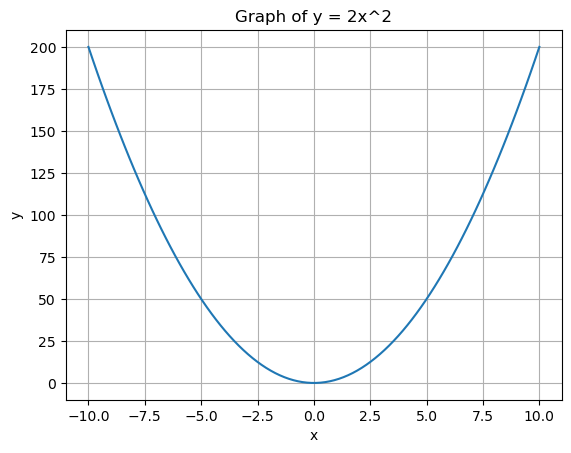

> {'output_1': '', 'output_2': "import matplotlib.pyplot as plt\nimport numpy as np\n\nx = np.linspace(-10, 10, 100)\ny = 2*x**2\n\nplt.plot(x, y)\nplt.xlabel('x')\nplt.ylabel('y')\nplt.title('Graph of y = 2x^2')\nplt.grid(True)\nplt.show()"}

Observation: The code to plot the graph of y = 2x^2 has been successfully generated and run using the python_generate_and_run_code_tool function.
Thoughts: The assigned task of plotting the graph of y = 2x^2 is almost complete. The code has been executed without errors.
Subtask identified: End Task
Task completed successfully!



[{'output_1': '',
  'output_2': "import matplotlib.pyplot as plt\nimport numpy as np\n\nx = np.linspace(-10, 10, 100)\ny = 2*x**2\n\nplt.plot(x, y)\nplt.xlabel('x')\nplt.ylabel('y')\nplt.title('Graph of y = 2x^2')\nplt.grid(True)\nplt.show()"}]

In [46]:
agent.reset()
agent.run('Plot me a graph of y = 2x^2')

In [47]:
agent.reset()
agent.run('What are the first 10 prime numbers?')

Observation: No subtasks have been completed yet for the assigned task.
Thoughts: To determine the first 10 prime numbers, a common approach is to use a prime number generation algorithm. This can involve iterating through numbers and checking for primality using methods like the Sieve of Eratosthenes.
Subtask identified: Generate a Python script that calculates the first 10 prime numbers using a prime number generation algorithm.
Calling function python_generate_and_run_code_tool with parameters {'instruction': 'Generate a Python script that calculates the first 10 prime numbers using a prime number generation algorithm.'}
Filtered Function Names: wikipedia_tool, python_generate_and_run_code_tool, get_text_from_url_tool
> {'output_1': '[2, 3, 5, 7, 11, 13, 17, 19, 23, 29]\n', 'output_2': 'import math\n\nprimes = []\nnum = 2\n\nwhile len(primes) < 10:\n    is_prime = True\n    for i in range(2, int(math.sqrt(num)) + 1):\n        if num % i == 0:\n            is_prime = False\n         

[{'output_1': '[2, 3, 5, 7, 11, 13, 17, 19, 23, 29]\n',
  'output_2': 'import math\n\nprimes = []\nnum = 2\n\nwhile len(primes) < 10:\n    is_prime = True\n    for i in range(2, int(math.sqrt(num)) + 1):\n        if num % i == 0:\n            is_prime = False\n            break\n    if is_prime:\n        primes.append(num)\n    num += 1\n\nprint(primes)'}]

In [48]:
agent.reset()
agent.run('Who is Joe Biden and how old is he now based on calculation?')

Observation: No subtasks have been completed yet for the assigned task.
Thoughts: To determine who Joe Biden is and his current age, we need to gather information from a reliable source such as Wikipedia. We can use the 'wikipedia_tool' Equipped Function to search for Joe Biden and extract relevant information.
Subtask identified: Use the 'wikipedia_tool' Equipped Function with the search query 'Joe Biden' to retrieve information about him.
Calling function wikipedia_tool with parameters {'search_query': 'Joe Biden'}
> {'output_1': "Page: Joe Biden\nSummary: Joseph Robinette Biden Jr. (born November 20, 1942) is an American politician who is the 46th and current president of the United States since 2021. A member of the Democratic Party, he previously served as the 47th vice president from 2009 to 2017 under President Barack Obama and represented Delaware in the United States Senate from 1973 to 2009.\nBorn in Scranton, Pennsylvania, Biden moved with his family to Delaware in 1953. He 

[{'output_1': "Page: Joe Biden\nSummary: Joseph Robinette Biden Jr. (born November 20, 1942) is an American politician who is the 46th and current president of the United States since 2021. A member of the Democratic Party, he previously served as the 47th vice president from 2009 to 2017 under President Barack Obama and represented Delaware in the United States Senate from 1973 to 2009.\nBorn in Scranton, Pennsylvania, Biden moved with his family to Delaware in 1953. He graduated from the University of Delaware before earning his law degree from Syracuse University. He was elected to the New Castle County Council in 1970 and to the U.S. Senate in 1972. As a senator, Biden drafted and led the effort to pass the Violent Crime Control and Law Enforcement Act and the Violence Against Women Act. He also oversaw six U.S. Supreme Court confirmation hearings, including the contentious hearings for Robert Bork and Clarence Thomas. Biden ran unsuccessfully for the Democratic presidential nomina

In [49]:
agent.reply_user()

Joe Biden is an American politician who is the 46th and current president of the United States since 2021. He was born on November 20, 1942. Joe Biden is currently 82 years old.


'Joe Biden is an American politician who is the 46th and current president of the United States since 2021. He was born on November 20, 1942. Joe Biden is currently 82 years old.'

In [50]:
agent.reset()
agent.run('What are the number of stars in TaskGen GitHub? (https://github.com/simbianai/taskgen)')

Observation: No subtasks have been completed yet for the Assigned Task.
Thoughts: To determine the number of stars in the TaskGen GitHub repository, we can use the get_text_from_url_tool Equipped Function to extract the necessary information from the GitHub page.
Subtask identified: Use the get_text_from_url_tool Equipped Function with the input URL being 'https://github.com/simbianai/taskgen' to retrieve the text content of the GitHub page.
Calling function get_text_from_url_tool with parameters {'url': 'https://github.com/simbianai/taskgen'}
> {'output_1': 'GitHub - simbianai/taskgen: Task-based Agentic Framework using StrictJSON as the core\nSkip to content\nNavigation Menu\nToggle navigation\nSign in\nProduct\nActions\nAutomate any workflow\nPackages\nHost and manage packages\nSecurity\nFind and fix vulnerabilities\nCodespaces\nInstant dev environments\nGitHub Copilot\nWrite better code with AI\nCode review\nManage code changes\nIssues\nPlan and track work\nDiscussions\nCollaborate

[{'output_1': 'GitHub - simbianai/taskgen: Task-based Agentic Framework using StrictJSON as the core\nSkip to content\nNavigation Menu\nToggle navigation\nSign in\nProduct\nActions\nAutomate any workflow\nPackages\nHost and manage packages\nSecurity\nFind and fix vulnerabilities\nCodespaces\nInstant dev environments\nGitHub Copilot\nWrite better code with AI\nCode review\nManage code changes\nIssues\nPlan and track work\nDiscussions\nCollaborate outside of code\nExplore\nAll features\nDocumentation\nGitHub Skills\nBlog\nSolutions\nBy size\nEnterprise\nTeams\nStartups\nBy industry\nHealthcare\nFinancial services\nManufacturing\nBy use case\nCI/CD & Automation\nDevOps\nDevSecOps\nResources\nResources\nLearning Pathways\nWhite papers, Ebooks, Webinars\nCustomer Stories\nPartners\nOpen Source\nGitHub Sponsors\nFund open source developers\nThe ReadME Project\nGitHub community articles\nRepositories\nTopics\nTrending\nCollections\nEnterprise\nEnterprise platform\nAI-powered developer platfor

In [51]:
agent.reply_user()

TaskGen GitHub repository has 95 stars.


'TaskGen GitHub repository has 95 stars.'

# Code as Action
- Executable Code Actions Elicit Better LLM Agents (Wang et al, 2024)
- https://arxiv.org/abs/2402.01030

- **How to use it**: Equip `python_generate_and_run_code_tool` and set `code_action = True` to make this function be used as default other than `end_task`. Also mention to use `python_generate_and_run_code_tool` as default in the Agent prompt.

- My take:
    - It is not as robust as the way we do modular function calling like the rest of TaskGen
    - Should use better LLMs like `gpt-4-turbo` to be viable
    - Try to specify 'at one go' in the task to encourage LLM to use all Equipped Functions in the same code

In [52]:
def return_random_person() -> str:
    '''Returns a random person name'''
    import numpy as np
    return np.random.choice(['Alice', 'Bob', 'Cindy', 'Don', 'Edward'])

In [53]:
agent = Agent('Code Agent', 
'''Uses code to solve tasks''',
              code_action = True, # this forces python_generate_and_run_code_tool to be the default action
             summarise_subtasks_count = 10,
             llm = llm).assign_functions(
    [python_generate_and_run_code_tool, return_random_person])

In [54]:
agent.reset()
agent.run('Generate three random names in one go')

Observation: No progress has been made on the Assigned Task yet.
Thoughts: To generate three random names in one go, I can utilize the 'return_random_person' function three times to get the desired output.
Subtask identified: Use the 'return_random_person' function three times to generate three random names.
Calling function python_generate_and_run_code_tool with parameters {'instruction': "Use the 'return_random_person' function three times to generate three random names."}
Filtered Function Names: python_generate_and_run_code_tool, return_random_person
> {'output_1': "{'output_1': 'Edward'}\n{'output_1': 'Don'}\n{'output_1': 'Don'}\n", 'output_2': 'name1 = return_random_person()\nname2 = return_random_person()\nname3 = return_random_person()\nprint(name1)\nprint(name2)\nprint(name3)'}

Observation: Three random names have been successfully generated using the 'return_random_person' function three times.
Thoughts: The task of generating three random names in one go has been completed.

[{'output_1': "{'output_1': 'Edward'}\n{'output_1': 'Don'}\n{'output_1': 'Don'}\n",
  'output_2': 'name1 = return_random_person()\nname2 = return_random_person()\nname3 = return_random_person()\nprint(name1)\nprint(name2)\nprint(name3)'}]